In [1]:
import os
import requests
import dotenv
import time
import numpy as np
import pandas as pd
import yfinance
import alpaca_trade_api as alpaca_api
import krakenex
import pykrakenapi
import pandas_montecarlo

%matplotlib inline

In [2]:
def random_portfolios_generator(tickers, n):
    random_portfolios = pd.DataFrame({'ticker':tickers})
    for n in range(0, n):
        random_portfolios[f'random weights {n+1}'] = [np.random.rand() for i in range (0, len(tickers))]
        random_portfolios[f'random weights {n+1}'] = random_portfolios[f'random weights {n+1}'] / sum(random_portfolios[f'random weights {n+1}'])
    return(random_portfolios)

In [3]:
dotenv.load_dotenv()

True

In [4]:
alpaca_api_key = os.getenv('alpaca_api_key')
alpaca_secret_key = os.getenv('alpaca_secret_key')
kraken_api_key = os.getenv('kraken_api_key')
kraken_secret_key = os.getenv('kraken_secret_key')

print(type(alpaca_api_key))
print(type(alpaca_secret_key))
print(type(kraken_api_key))
print(type(kraken_secret_key))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [5]:
alpaca = alpaca_api.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")

faangmula_tickers =  ['AAPL',  'ABNB', 'AMZN', 'FB', 'GOOG', 'LYFT', 'MSFT', 'NFLX', 'UBER']
start = pd.Timestamp('2015-12-01', tz='America/New_York').isoformat()

faangmula_original = alpaca.get_bars(faangmula_tickers, alpaca_api.TimeFrame.Day, start = start).df
faangmula_original

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2015-12-01 05:00:00+00:00,118.73,118.810,116.86,117.34,34852374,187129,117.756760,AAPL
2015-12-02 05:00:00+00:00,117.00,118.110,116.08,116.28,33385643,180616,117.151198,AAPL
2015-12-03 05:00:00+00:00,116.55,116.790,114.22,115.20,41560785,245330,115.434888,AAPL
2015-12-04 05:00:00+00:00,115.20,119.250,115.11,119.03,57776977,307788,118.187290,AAPL
2015-12-07 05:00:00+00:00,118.98,119.860,117.81,118.28,32080754,190809,118.509111,AAPL
...,...,...,...,...,...,...,...,...
2022-04-07 04:00:00+00:00,33.34,33.340,31.02,32.27,34513446,230097,32.017072,UBER
2022-04-08 04:00:00+00:00,31.87,32.551,31.58,32.05,17958279,132296,32.171104,UBER
2022-04-11 04:00:00+00:00,31.38,32.690,31.11,32.04,19651398,129735,32.087568,UBER


In [6]:
faangmula = faangmula_original.drop(['open', 'high', 'low', 'volume', 'trade_count', 'vwap'], axis = 1).pivot(columns = 'symbol')
faangmula.index = faangmula.index.date
faangmula.columns = faangmula_tickers
faangmula

,AAPL,ABNB,AMZN,FB,GOOG,LYFT,MSFT,NFLX,UBER
2015-12-01,117.34,NaN,679.06,107.12,767.04,NaN,55.22,125.37,NaN
2015-12-02,116.28,NaN,676.01,106.07,762.38,NaN,55.21,128.93,NaN
2015-12-03,115.20,NaN,666.25,104.38,752.54,NaN,54.20,126.81,NaN
2015-12-04,119.03,NaN,672.64,106.18,766.81,NaN,55.91,130.93,NaN
2015-12-07,118.28,NaN,669.83,105.61,763.25,NaN,55.81,125.36,NaN
...,...,...,...,...,...,...,...,...,...
2022-04-07,172.14,165.91,3155.69,222.95,2729.30,34.61,301.37,362.15,32.27
2022-04-08,170.09,162.56,3089.21,222.33,2680.21,33.59,296.97,355.88,32.05
2022-04-11,165.75,160.25,3022.44,216.46,2595.93,33.32,285.26,348.00,32.04
2022-04-12,167.66,160.11,3015.75,214.14,2567.49,33.45,282.06,344.10,31.99


In [7]:
# Market capitalization data in trillions of dollars, sourced from Trading View on April 6, 2022.

faangmula_caps_list = [2.804, 0.105855, 1.616, 0.60781, 1.81, 0.012576, 2.245, 0.163534, 0.065299]
faangmula_cap_portfolio = pd.DataFrame({'tickers':faangmula_tickers, 'market cap weights':[market_cap / sum(faangmula_caps_list) for market_cap in faangmula_caps_list]}).set_index('tickers')
faangmula_cap_portfolio

,market cap weights
tickers,
AAPL,0.297347
ABNB,0.011225
AMZN,0.171367
FB,0.064454
GOOG,0.191939
LYFT,0.001334
MSFT,0.238068
NFLX,0.017342
UBER,0.006925


In [8]:
faangmula_cap_daily_returns = faangmula.pct_change().fillna(0.0).dot(faangmula_cap_portfolio)
faangmula_cap_daily_returns.columns = ['faangmula index']
faangmula_cap_daily_returns

,faangmula index
2015-12-01,0.000000
2015-12-02,-0.004804
2015-12-03,-0.013380
2015-12-04,0.024355
2015-12-07,-0.004990
...,...
2022-04-07,-0.000202
2022-04-08,-0.014872
2022-04-11,-0.028972
2022-04-12,-0.002627


In [9]:
random_faangmula_portfolios = random_portfolios_generator(faangmula_tickers, 1000)
random_faangmula_portfolios

/usr/local/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


,ticker,random weights 1,random weights 2,random weights 3,random weights 4,random weights 5,random weights 6,random weights 7,random weights 8,random weights 9,...,random weights 991,random weights 992,random weights 993,random weights 994,random weights 995,random weights 996,random weights 997,random weights 998,random weights 999,random weights 1000
0,AAPL,0.086122,0.030845,0.025073,0.004873,0.217247,0.049033,0.140942,0.166150,0.052950,...,0.012793,0.072345,0.182328,0.062993,0.160281,0.162548,0.012116,0.056508,0.156605,0.082153
1,ABNB,0.136466,0.026654,0.179150,0.017286,0.052697,0.134596,0.126016,0.093248,0.039744,...,0.147387,0.045607,0.013067,0.170099,0.111029,0.124519,0.151040,0.187765,0.187592,0.089746
2,AMZN,0.234380,0.183788,0.079823,0.212690,0.155701,0.120201,0.111617,0.062426,0.106271,...,0.097403,0.200440,0.223476,0.178126,0.180113,0.034155,0.109442,0.114881,0.014573,0.075544
3,FB,0.015183,0.181888,0.010116,0.217428,0.072997,0.021636,0.081026,0.058261,0.181709,...,0.071820,0.048213,0.030601,0.114946,0.003631,0.102041,0.099529,0.230109,0.028750,0.149937
4,GOOG,0.088685,0.079924,0.171838,0.030795,0.170577,0.075545,0.150571,0.156351,0.160965,...,0.173311,0.066210,0.095577,0.094341,0.042498,0.136676,0.177207,0.069464,0.132336,0.172252
5,LYFT,0.120788,0.200674,0.065486,0.185766,0.111800,0.072257,0.146198,0.205800,0.066167,...,0.128725,0.181072,0.042658,0.096967,0.174826,0.159882,0.128490,0.021210,0.173550,0.148515
6,MSFT,0.106521,0.136611,0.201875,0.102706,0.019755,0.124375,0.067237,0.087378,0.042955,...,0.086092,0.218485,0.221333,0.169182,0.118665,0.059121,0.034792,0.183178,0.115312,0.034027
7,NFLX,0.082305,0.022851,0.108120,0.145351,0.077167,0.205474,0.129317,0.133312,0.147411,...,0.174359,0.064698,0.004953,0.038334,0.044014,0.088948,0.138593,0.100578,0.132936,0.150856
8,UBER,0.129551,0.136765,0.158520,0.083105,0.122060,0.196882,0.047077,0.037075,0.201828,...,0.108110,0.102930,0.186005,0.075011,0.164942,0.132110,0.148791,0.036307,0.058347,0.096968


In [10]:
random_faangmula_daily_returns_list = []
for n in range(0, (len(random_faangmula_portfolios.columns) - 1)):
        random_faangmula_daily_returns_list.append(faangmula.pct_change().fillna(0.0).dot(list(random_faangmula_portfolios.loc[:, f'random weights {n + 1}'])))

random_faangmula_daily_returns = pd.concat(random_faangmula_daily_returns_list, axis = 'columns', join = 'inner')

for n in range(0, (len(random_faangmula_portfolios.columns) - 1)):
        random_faangmula_daily_returns = random_faangmula_daily_returns.rename(columns = {n: f'random faangmula portfolio {n + 1}'})

random_faangmula_daily_returns

,random faangmula portfolio 1,random faangmula portfolio 2,random faangmula portfolio 3,random faangmula portfolio 4,random faangmula portfolio 5,random faangmula portfolio 6,random faangmula portfolio 7,random faangmula portfolio 8,random faangmula portfolio 9,random faangmula portfolio 10,...,random faangmula portfolio 991,random faangmula portfolio 992,random faangmula portfolio 993,random faangmula portfolio 994,random faangmula portfolio 995,random faangmula portfolio 996,random faangmula portfolio 997,random faangmula portfolio 998,random faangmula portfolio 999,random faangmula portfolio 1000
2015-12-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-12-02,-0.000200,-0.002748,0.001305,0.000791,-0.002226,0.004158,0.000176,0.000467,0.000463,-0.001862,...,0.002626,-0.000631,-0.003431,-0.002011,-0.001322,-0.000937,0.001276,-0.000881,0.001188,0.000680
2015-12-03,-0.008872,-0.009744,-0.009235,-0.011247,-0.009261,-0.009165,-0.009511,-0.009181,-0.010209,-0.006378,...,-0.009348,-0.010249,-0.010772,-0.009931,-0.007590,-0.007937,-0.008481,-0.011751,-0.008126,-0.009569
2015-12-04,0.013089,0.012493,0.014914,0.014498,0.016340,0.015188,0.016332,0.017180,0.015110,0.009087,...,0.014265,0.015410,0.017689,0.014157,0.013099,0.014838,0.012130,0.017313,0.016309,0.015283
2015-12-07,-0.005707,-0.003526,-0.006304,-0.008597,-0.006521,-0.010242,-0.008110,-0.008174,-0.008848,-0.002911,...,-0.009249,-0.005003,-0.003297,-0.004129,-0.004064,-0.006239,-0.007849,-0.007000,-0.007678,-0.008916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-07,-0.010668,-0.013897,-0.008591,-0.013865,-0.010750,-0.012326,-0.009502,-0.011392,-0.013094,-0.012578,...,-0.011778,-0.011682,-0.008014,-0.006365,-0.012722,-0.011761,-0.012986,-0.002469,-0.009473,-0.012332
2022-04-08,-0.017779,-0.015957,-0.016546,-0.016104,-0.015954,-0.016098,-0.017358,-0.018053,-0.013578,-0.018978,...,-0.017304,-0.017678,-0.014790,-0.016457,-0.017491,-0.015927,-0.016672,-0.014062,-0.017918,-0.016044
2022-04-11,-0.019426,-0.020002,-0.021511,-0.020463,-0.020373,-0.018805,-0.021378,-0.021432,-0.019624,-0.017288,...,-0.020196,-0.021717,-0.022720,-0.022199,-0.018103,-0.019274,-0.018541,-0.024485,-0.020801,-0.020286
2022-04-12,-0.002628,-0.004119,-0.005503,-0.005283,-0.001379,-0.004601,-0.002958,-0.002372,-0.005561,-0.001615,...,-0.005452,-0.003522,-0.002442,-0.004149,-0.000553,-0.002145,-0.004917,-0.006150,-0.002347,-0.004437


In [11]:
faangmula_daily_returns = pd.concat([faangmula_cap_daily_returns, random_faangmula_daily_returns], axis = 1, join = 'inner')
faangmula_daily_returns

,faangmula index,random faangmula portfolio 1,random faangmula portfolio 2,random faangmula portfolio 3,random faangmula portfolio 4,random faangmula portfolio 5,random faangmula portfolio 6,random faangmula portfolio 7,random faangmula portfolio 8,random faangmula portfolio 9,...,random faangmula portfolio 991,random faangmula portfolio 992,random faangmula portfolio 993,random faangmula portfolio 994,random faangmula portfolio 995,random faangmula portfolio 996,random faangmula portfolio 997,random faangmula portfolio 998,random faangmula portfolio 999,random faangmula portfolio 1000
2015-12-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-12-02,-0.004804,-0.000200,-0.002748,0.001305,0.000791,-0.002226,0.004158,0.000176,0.000467,0.000463,...,0.002626,-0.000631,-0.003431,-0.002011,-0.001322,-0.000937,0.001276,-0.000881,0.001188,0.000680
2015-12-03,-0.013380,-0.008872,-0.009744,-0.009235,-0.011247,-0.009261,-0.009165,-0.009511,-0.009181,-0.010209,...,-0.009348,-0.010249,-0.010772,-0.009931,-0.007590,-0.007937,-0.008481,-0.011751,-0.008126,-0.009569
2015-12-04,0.024355,0.013089,0.012493,0.014914,0.014498,0.016340,0.015188,0.016332,0.017180,0.015110,...,0.014265,0.015410,0.017689,0.014157,0.013099,0.014838,0.012130,0.017313,0.016309,0.015283
2015-12-07,-0.004990,-0.005707,-0.003526,-0.006304,-0.008597,-0.006521,-0.010242,-0.008110,-0.008174,-0.008848,...,-0.009249,-0.005003,-0.003297,-0.004129,-0.004064,-0.006239,-0.007849,-0.007000,-0.007678,-0.008916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-07,-0.000202,-0.010668,-0.013897,-0.008591,-0.013865,-0.010750,-0.012326,-0.009502,-0.011392,-0.013094,...,-0.011778,-0.011682,-0.008014,-0.006365,-0.012722,-0.011761,-0.012986,-0.002469,-0.009473,-0.012332
2022-04-08,-0.014872,-0.017779,-0.015957,-0.016546,-0.016104,-0.015954,-0.016098,-0.017358,-0.018053,-0.013578,...,-0.017304,-0.017678,-0.014790,-0.016457,-0.017491,-0.015927,-0.016672,-0.014062,-0.017918,-0.016044
2022-04-11,-0.028972,-0.019426,-0.020002,-0.021511,-0.020463,-0.020373,-0.018805,-0.021378,-0.021432,-0.019624,...,-0.020196,-0.021717,-0.022720,-0.022199,-0.018103,-0.019274,-0.018541,-0.024485,-0.020801,-0.020286
2022-04-12,-0.002627,-0.002628,-0.004119,-0.005503,-0.005283,-0.001379,-0.004601,-0.002958,-0.002372,-0.005561,...,-0.005452,-0.003522,-0.002442,-0.004149,-0.000553,-0.002145,-0.004917,-0.006150,-0.002347,-0.004437


In [12]:
faangmula_correlations = faangmula_daily_returns.corr()
faangmula_correlations

,faangmula index,random faangmula portfolio 1,random faangmula portfolio 2,random faangmula portfolio 3,random faangmula portfolio 4,random faangmula portfolio 5,random faangmula portfolio 6,random faangmula portfolio 7,random faangmula portfolio 8,random faangmula portfolio 9,...,random faangmula portfolio 991,random faangmula portfolio 992,random faangmula portfolio 993,random faangmula portfolio 994,random faangmula portfolio 995,random faangmula portfolio 996,random faangmula portfolio 997,random faangmula portfolio 998,random faangmula portfolio 999,random faangmula portfolio 1000
faangmula index,1.000000,0.848521,0.795151,0.821116,0.807299,0.919088,0.798106,0.894725,0.875753,0.831947,...,0.797999,0.852621,0.934034,0.878300,0.821526,0.841298,0.772494,0.892986,0.848409,0.843316
random faangmula portfolio 1,0.848521,1.000000,0.967268,0.981525,0.962394,0.970441,0.977911,0.981382,0.971734,0.965637,...,0.977630,0.988928,0.963270,0.983877,0.980132,0.971405,0.977625,0.924198,0.969394,0.975600
random faangmula portfolio 2,0.795151,0.967268,1.000000,0.950853,0.977579,0.944180,0.939999,0.950982,0.951369,0.968336,...,0.958279,0.984099,0.937001,0.964188,0.961699,0.963561,0.970867,0.897212,0.934611,0.971612
random faangmula portfolio 3,0.821116,0.981525,0.950853,1.000000,0.948005,0.941170,0.983744,0.966567,0.954480,0.966842,...,0.986853,0.970988,0.938472,0.976389,0.951594,0.958997,0.983293,0.930941,0.963304,0.971181
random faangmula portfolio 4,0.807299,0.962394,0.977579,0.948005,1.000000,0.935062,0.958983,0.959002,0.946030,0.982364,...,0.975321,0.971959,0.919235,0.962595,0.925196,0.939438,0.973896,0.934990,0.923243,0.981350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
random faangmula portfolio 996,0.841298,0.971405,0.963561,0.958997,0.939438,0.979959,0.953223,0.981371,0.988796,0.959274,...,0.958484,0.970860,0.948604,0.959441,0.984278,1.000000,0.965422,0.897434,0.988849,0.980161
random faangmula portfolio 997,0.772494,0.977625,0.970867,0.983293,0.973896,0.937550,0.983230,0.965646,0.956257,0.981672,...,0.995291,0.968457,0.911711,0.966821,0.950535,0.965422,1.000000,0.918461,0.957138,0.986705
random faangmula portfolio 998,0.892986,0.924198,0.897212,0.930941,0.934990,0.916544,0.915201,0.946789,0.908954,0.940436,...,0.933457,0.912071,0.912049,0.968343,0.859692,0.897434,0.918461,1.000000,0.902624,0.941152
random faangmula portfolio 999,0.848409,0.969394,0.934611,0.963304,0.923243,0.969489,0.955925,0.985858,0.991768,0.938410,...,0.961236,0.962055,0.933945,0.957225,0.972916,0.988849,0.957138,0.902624,1.000000,0.971703


In [13]:
low_correlation_faangmula_original = faangmula_correlations.sort_values('faangmula index')['faangmula index'].head(10).reset_index().rename({'index': 'portfolio', 'faangmula index': 'faangmula index correlation'}, axis = 1)
low_correlation_faangmula_original.loc[len(low_correlation_faangmula_original.values)] = ['faangmula index', 1.0]
low_correlation_faangmula_original

,portfolio,faangmula index correlation
0,random faangmula portfolio 765,0.648110
1,random faangmula portfolio 886,0.661418
2,random faangmula portfolio 818,0.664116
3,random faangmula portfolio 453,0.669277
4,random faangmula portfolio 215,0.677155
5,random faangmula portfolio 967,0.687774
6,random faangmula portfolio 92,0.696756
7,random faangmula portfolio 990,0.698648
8,random faangmula portfolio 451,0.700361
9,random faangmula portfolio 346,0.700981


In [14]:
variances = []
covariances = []
for portfolio in low_correlation_faangmula_original['portfolio']:
    variance = faangmula_daily_returns[f'{portfolio}'].var()
    covariance = faangmula_daily_returns[f'{portfolio}'].cov(faangmula_daily_returns['faangmula index'])
    variances.append(variance)
    covariances.append(covariance)

lc_intermediate_1 = pd.concat([low_correlation_faangmula_original, pd.DataFrame(variances)], axis = 1).rename({0: 'portfolio variance'}, axis = 1)
lc_intermediate_2 = pd.concat([lc_intermediate_1, pd.DataFrame(covariances)], axis = 1).rename({0: 'faangmula index covariance'}, axis = 1)
lc_intermediate_2

,portfolio,faangmula index correlation,portfolio variance,faangmula index covariance
0,random faangmula portfolio 765,0.648110,0.000345,0.000196
1,random faangmula portfolio 886,0.661418,0.000212,0.000157
2,random faangmula portfolio 818,0.664116,0.000247,0.000170
3,random faangmula portfolio 453,0.669277,0.000256,0.000175
4,random faangmula portfolio 215,0.677155,0.000289,0.000188
5,random faangmula portfolio 967,0.687774,0.000228,0.000169
6,random faangmula portfolio 92,0.696756,0.000256,0.000182
7,random faangmula portfolio 990,0.698648,0.000214,0.000167
8,random faangmula portfolio 451,0.700361,0.000225,0.000171
9,random faangmula portfolio 346,0.700981,0.000237,0.000176


In [15]:
betas = []
for portfolio in low_correlation_faangmula_original['portfolio']:
    beta = lc_intermediate_2.set_index('portfolio').at[f'{portfolio}', 'faangmula index covariance'] / lc_intermediate_2.set_index('portfolio').at[f'{portfolio}', 'portfolio variance']
    betas.append(beta)

lc_intermediate_3 = pd.concat([lc_intermediate_2, pd.DataFrame(betas)], axis = 1).rename({0: 'faangmula index beta'}, axis = 1)
lc_intermediate_3

,portfolio,faangmula index correlation,portfolio variance,faangmula index covariance,faangmula index beta
0,random faangmula portfolio 765,0.648110,0.000345,0.000196,0.568655
1,random faangmula portfolio 886,0.661418,0.000212,0.000157,0.741362
2,random faangmula portfolio 818,0.664116,0.000247,0.000170,0.688878
3,random faangmula portfolio 453,0.669277,0.000256,0.000175,0.682009
4,random faangmula portfolio 215,0.677155,0.000289,0.000188,0.648965
5,random faangmula portfolio 967,0.687774,0.000228,0.000169,0.742950
6,random faangmula portfolio 92,0.696756,0.000256,0.000182,0.709759
7,random faangmula portfolio 990,0.698648,0.000214,0.000167,0.779339
8,random faangmula portfolio 451,0.700361,0.000225,0.000171,0.762107
9,random faangmula portfolio 346,0.700981,0.000237,0.000176,0.742677


In [16]:
average_returns = []
for portfolio in low_correlation_faangmula_original['portfolio']:
    average_return = faangmula_daily_returns[f'{portfolio}'].mean()
    average_returns.append(average_return)

lc_intermediate_4 = pd.concat([lc_intermediate_3, pd.DataFrame(average_returns)], axis = 1).rename({0: 'average daily return'}, axis = 1)
lc_intermediate_4

,portfolio,faangmula index correlation,portfolio variance,faangmula index covariance,faangmula index beta,average daily return
0,random faangmula portfolio 765,0.648110,0.000345,0.000196,0.568655,0.000350
1,random faangmula portfolio 886,0.661418,0.000212,0.000157,0.741362,0.000463
2,random faangmula portfolio 818,0.664116,0.000247,0.000170,0.688878,0.000349
3,random faangmula portfolio 453,0.669277,0.000256,0.000175,0.682009,0.000305
4,random faangmula portfolio 215,0.677155,0.000289,0.000188,0.648965,0.000482
5,random faangmula portfolio 967,0.687774,0.000228,0.000169,0.742950,0.000463
6,random faangmula portfolio 92,0.696756,0.000256,0.000182,0.709759,0.000498
7,random faangmula portfolio 990,0.698648,0.000214,0.000167,0.779339,0.000508
8,random faangmula portfolio 451,0.700361,0.000225,0.000171,0.762107,0.000506
9,random faangmula portfolio 346,0.700981,0.000237,0.000176,0.742677,0.000441


In [17]:
stds = []
for portfolio in low_correlation_faangmula_original['portfolio']:
    std = faangmula_daily_returns[f'{portfolio}'].std()
    stds.append(std)

lc_intermediate_5 = pd.concat([lc_intermediate_4, pd.DataFrame(stds)], axis = 1).rename({0: 'standard deviation'}, axis = 1)
lc_intermediate_5

,portfolio,faangmula index correlation,portfolio variance,faangmula index covariance,faangmula index beta,average daily return,standard deviation
0,random faangmula portfolio 765,0.648110,0.000345,0.000196,0.568655,0.000350,0.018585
1,random faangmula portfolio 886,0.661418,0.000212,0.000157,0.741362,0.000463,0.014548
2,random faangmula portfolio 818,0.664116,0.000247,0.000170,0.688878,0.000349,0.015720
3,random faangmula portfolio 453,0.669277,0.000256,0.000175,0.682009,0.000305,0.016002
4,random faangmula portfolio 215,0.677155,0.000289,0.000188,0.648965,0.000482,0.017015
5,random faangmula portfolio 967,0.687774,0.000228,0.000169,0.742950,0.000463,0.015095
6,random faangmula portfolio 92,0.696756,0.000256,0.000182,0.709759,0.000498,0.016008
7,random faangmula portfolio 990,0.698648,0.000214,0.000167,0.779339,0.000508,0.014618
8,random faangmula portfolio 451,0.700361,0.000225,0.000171,0.762107,0.000506,0.014985
9,random faangmula portfolio 346,0.700981,0.000237,0.000176,0.742677,0.000441,0.015391


In [18]:
zero_sharpes = []
for portfolio in low_correlation_faangmula_original['portfolio']:
    zero_sharpe = (lc_intermediate_5.set_index('portfolio').at[f'{portfolio}', 'average daily return'] - 0) / lc_intermediate_5.set_index('portfolio').at[f'{portfolio}', 'standard deviation']
    zero_sharpes.append(zero_sharpe)

lc_intermediate_6 = pd.concat([lc_intermediate_5, pd.DataFrame(zero_sharpes)], axis = 1).rename({0: 'zero sharpe ratio'}, axis = 1)
lc_intermediate_6

,portfolio,faangmula index correlation,portfolio variance,faangmula index covariance,faangmula index beta,average daily return,standard deviation,zero sharpe ratio
0,random faangmula portfolio 765,0.648110,0.000345,0.000196,0.568655,0.000350,0.018585,0.018848
1,random faangmula portfolio 886,0.661418,0.000212,0.000157,0.741362,0.000463,0.014548,0.031850
2,random faangmula portfolio 818,0.664116,0.000247,0.000170,0.688878,0.000349,0.015720,0.022190
3,random faangmula portfolio 453,0.669277,0.000256,0.000175,0.682009,0.000305,0.016002,0.019043
4,random faangmula portfolio 215,0.677155,0.000289,0.000188,0.648965,0.000482,0.017015,0.028324
5,random faangmula portfolio 967,0.687774,0.000228,0.000169,0.742950,0.000463,0.015095,0.030665
6,random faangmula portfolio 92,0.696756,0.000256,0.000182,0.709759,0.000498,0.016008,0.031101
7,random faangmula portfolio 990,0.698648,0.000214,0.000167,0.779339,0.000508,0.014618,0.034767
8,random faangmula portfolio 451,0.700361,0.000225,0.000171,0.762107,0.000506,0.014985,0.033782
9,random faangmula portfolio 346,0.700981,0.000237,0.000176,0.742677,0.000441,0.015391,0.028629


In [19]:
faangmula_sharpes = []
for portfolio in low_correlation_faangmula_original['portfolio']:
    faangmula_sharpe = (lc_intermediate_6.set_index('portfolio').at[f'{portfolio}', 'average daily return'] - lc_intermediate_5.set_index('portfolio').at['faangmula index', 'average daily return']) / lc_intermediate_6.set_index('portfolio').at[f'{portfolio}', 'standard deviation']
    faangmula_sharpes.append(faangmula_sharpe)
lc_intermediate_7 = pd.concat([lc_intermediate_6, pd.DataFrame(faangmula_sharpes)], axis = 1).rename({0: 'faangmula sharpe ratio'}, axis = 1)
lc_intermediate_7

,portfolio,faangmula index correlation,portfolio variance,faangmula index covariance,faangmula index beta,average daily return,standard deviation,zero sharpe ratio,faangmula sharpe ratio
0,random faangmula portfolio 765,0.648110,0.000345,0.000196,0.568655,0.000350,0.018585,0.018848,-0.031930
1,random faangmula portfolio 886,0.661418,0.000212,0.000157,0.741362,0.000463,0.014548,0.031850,-0.033017
2,random faangmula portfolio 818,0.664116,0.000247,0.000170,0.688878,0.000349,0.015720,0.022190,-0.037841
3,random faangmula portfolio 453,0.669277,0.000256,0.000175,0.682009,0.000305,0.016002,0.019043,-0.039930
4,random faangmula portfolio 215,0.677155,0.000289,0.000188,0.648965,0.000482,0.017015,0.028324,-0.027140
5,random faangmula portfolio 967,0.687774,0.000228,0.000169,0.742950,0.000463,0.015095,0.030665,-0.031850
6,random faangmula portfolio 92,0.696756,0.000256,0.000182,0.709759,0.000498,0.016008,0.031101,-0.027852
7,random faangmula portfolio 990,0.698648,0.000214,0.000167,0.779339,0.000508,0.014618,0.034767,-0.029790
8,random faangmula portfolio 451,0.700361,0.000225,0.000171,0.762107,0.000506,0.014985,0.033782,-0.029193
9,random faangmula portfolio 346,0.700981,0.000237,0.000176,0.742677,0.000441,0.015391,0.028629,-0.032686


In [20]:
cumulative_returns = []
for portfolio in low_correlation_faangmula_original['portfolio']:
    cumulative_return = (1 + faangmula_daily_returns[f'{portfolio}']).cumprod()
    cumulative_returns.append(cumulative_return)

cumulative_returns_df = pd.DataFrame(cumulative_returns)
cumulative_returns_df

,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-14,...,2022-03-31,2022-04-01,2022-04-04,2022-04-05,2022-04-06,2022-04-07,2022-04-08,2022-04-11,2022-04-12,2022-04-13
random faangmula portfolio 765,1.0,0.998275,0.993399,1.003255,0.999620,1.001381,0.993641,0.994702,0.983850,0.987343,...,1.426791,1.424047,1.462691,1.413033,1.365261,1.334164,1.314741,1.298799,1.299658,1.330792
random faangmula portfolio 886,1.0,1.000416,0.993753,1.004311,1.000993,1.002495,0.995914,0.996880,0.986794,0.994469,...,1.880708,1.879740,1.930182,1.871242,1.804685,1.782450,1.750924,1.719215,1.713279,1.774858
random faangmula portfolio 818,1.0,0.998050,0.993381,1.002524,0.999702,1.000623,0.993862,0.994685,0.985824,0.989136,...,1.519343,1.516375,1.558289,1.507896,1.458442,1.435469,1.410171,1.388784,1.388471,1.435556
random faangmula portfolio 453,1.0,0.997036,0.993354,1.003016,1.000989,1.001571,0.994511,0.996072,0.987055,0.987666,...,1.387860,1.381335,1.421260,1.374790,1.332757,1.315544,1.290023,1.270328,1.274146,1.324507
random faangmula portfolio 215,1.0,0.998052,0.990909,0.999852,0.996612,0.999378,0.990923,0.990788,0.977996,0.987445,...,1.847849,1.845342,1.896991,1.836671,1.774439,1.737683,1.707971,1.681169,1.676568,1.718796
random faangmula portfolio 967,1.0,1.001518,0.994490,1.005124,0.997473,1.000172,0.991819,0.990673,0.979121,0.986729,...,1.862593,1.864252,1.919244,1.860440,1.796964,1.767536,1.738277,1.709305,1.701279,1.750509
random faangmula portfolio 92,1.0,0.998982,0.990891,1.002921,0.999953,1.001956,0.993751,0.995379,0.982578,0.992411,...,1.935003,1.929780,1.985320,1.927168,1.861037,1.831998,1.799745,1.764963,1.758655,1.809358
random faangmula portfolio 990,1.0,1.002215,0.995424,1.006158,0.999483,1.002063,0.994030,0.992636,0.981125,0.988514,...,2.024115,2.023171,2.079133,2.012252,1.943453,1.914147,1.878943,1.847518,1.841606,1.904085
random faangmula portfolio 451,1.0,0.998196,0.991512,0.999879,0.997611,1.000040,0.992285,0.992073,0.980178,0.989176,...,2.000673,1.999783,2.052730,1.987979,1.920011,1.890961,1.856021,1.825113,1.821024,1.881847
random faangmula portfolio 346,1.0,1.002879,0.997280,1.009336,1.001363,1.003590,0.995408,0.994493,0.983454,0.987030,...,1.777755,1.776109,1.825355,1.764511,1.705013,1.677520,1.649298,1.625094,1.623471,1.676706


<AxesSubplot:title={'center':'Correlations Against FAANGMULA'}>

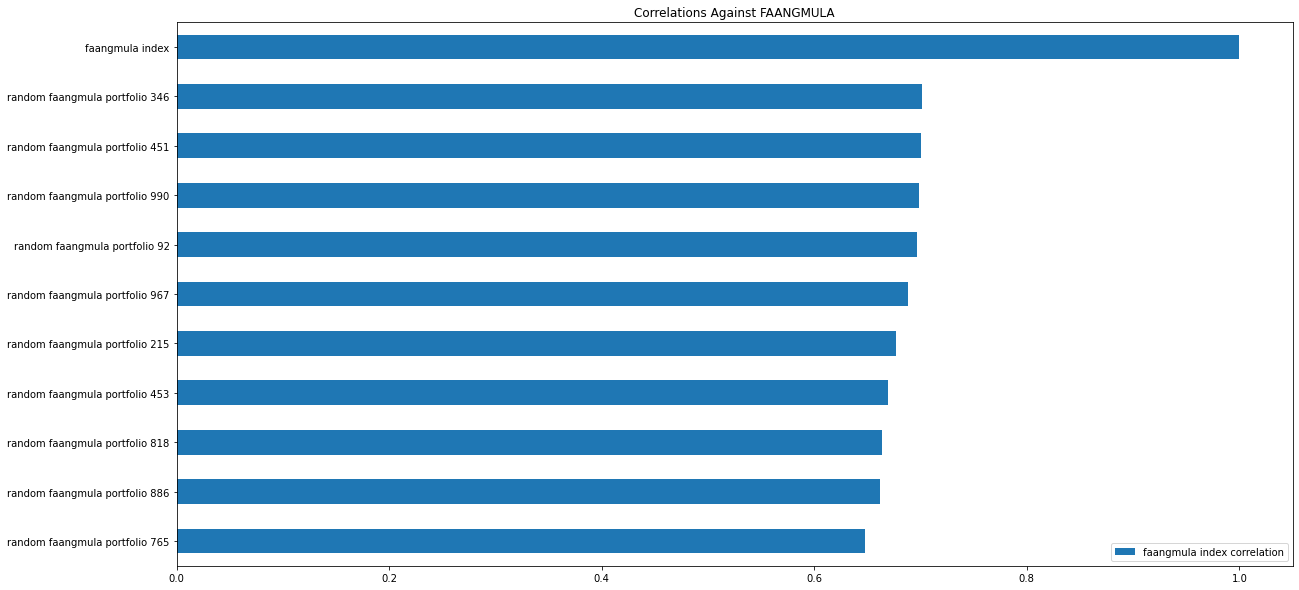

In [21]:
lc_intermediate_7.plot(kind = 'barh', x = 'portfolio', y = 'faangmula index correlation', xlabel = '', ylabel = 'Correlation Coefficient', figsize = (20, 10), title = 'Correlations Against FAANGMULA')

<AxesSubplot:title={'center':'Portfolio 309 Daily Returns'}, ylabel='Daily Return'>

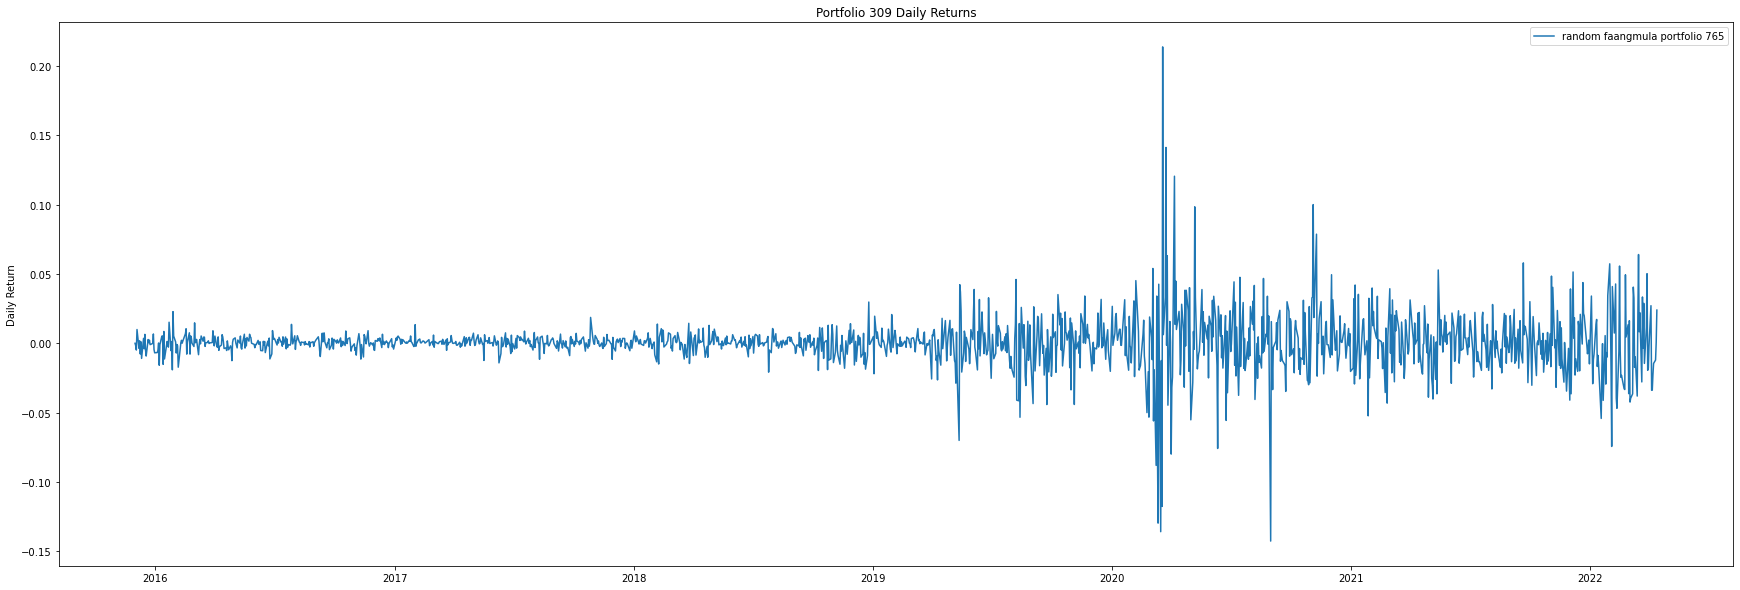

In [22]:
faangmula_daily_returns[list(low_correlation_faangmula_original['portfolio'].head(1))].plot(kind = 'line', xlabel = '', ylabel = 'Daily Return', figsize = (30, 10), title = 'Portfolio 309 Daily Returns')

<AxesSubplot:title={'center':'FAANGMULA Index Daily Returns'}, ylabel='Daily Return'>

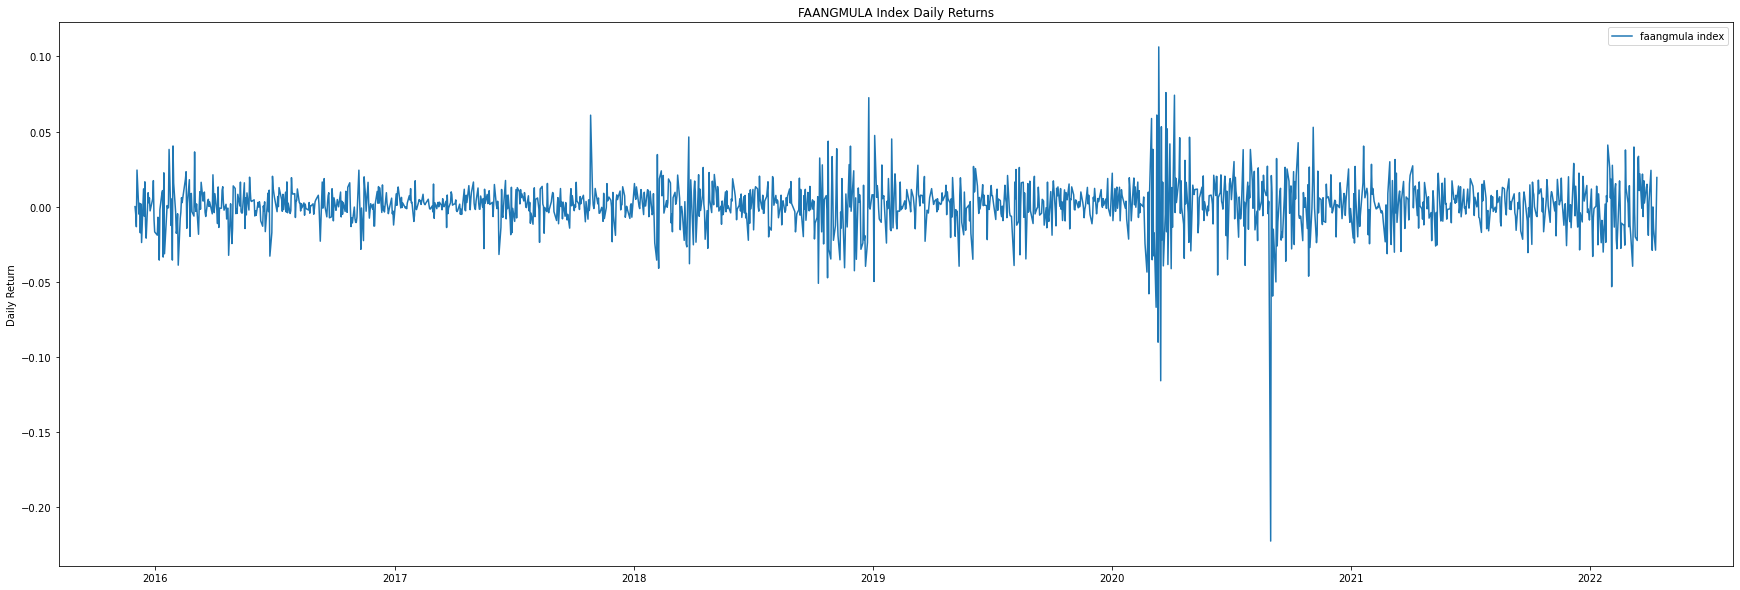

In [23]:
faangmula_daily_returns[list(low_correlation_faangmula_original['portfolio'].tail(1))].plot(kind = 'line', xlabel = '', ylabel = 'Daily Return', figsize = (30, 10), title = 'FAANGMULA Index Daily Returns')

<AxesSubplot:title={'center':'Betas Against FAANGMULA Index'}>

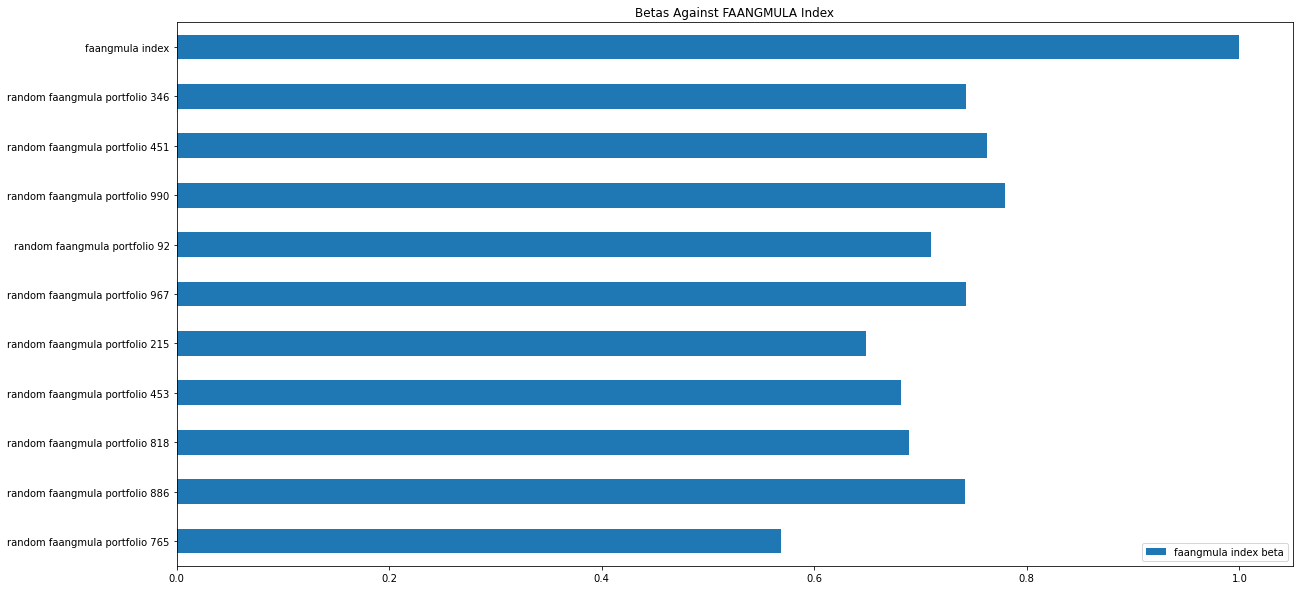

In [24]:
lc_intermediate_7.plot(kind = 'barh', x = 'portfolio', y = 'faangmula index beta', xlabel = '', ylabel = 'Beta', figsize = (20, 10), title = 'Betas Against FAANGMULA Index')

<AxesSubplot:title={'center':'Standard Deviations Vs. Betas On FAANGMULA Index'}, xlabel='Standard Deviation', ylabel='Beta'>

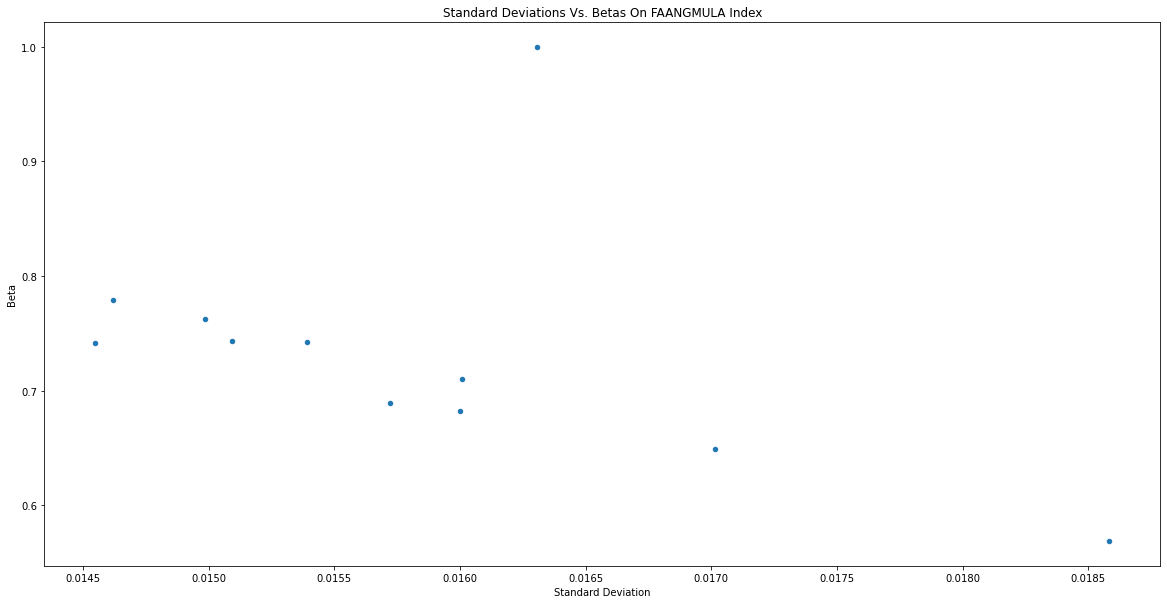

In [25]:
lc_intermediate_7.plot(kind = 'scatter', x = 'standard deviation', y = 'faangmula index beta', xlabel = 'Standard Deviation', ylabel = 'Beta', figsize = (20, 10), title = 'Standard Deviations Vs. Betas On FAANGMULA Index')

<AxesSubplot:title={'center':'Sharpe Ratios Against Zero Return'}>

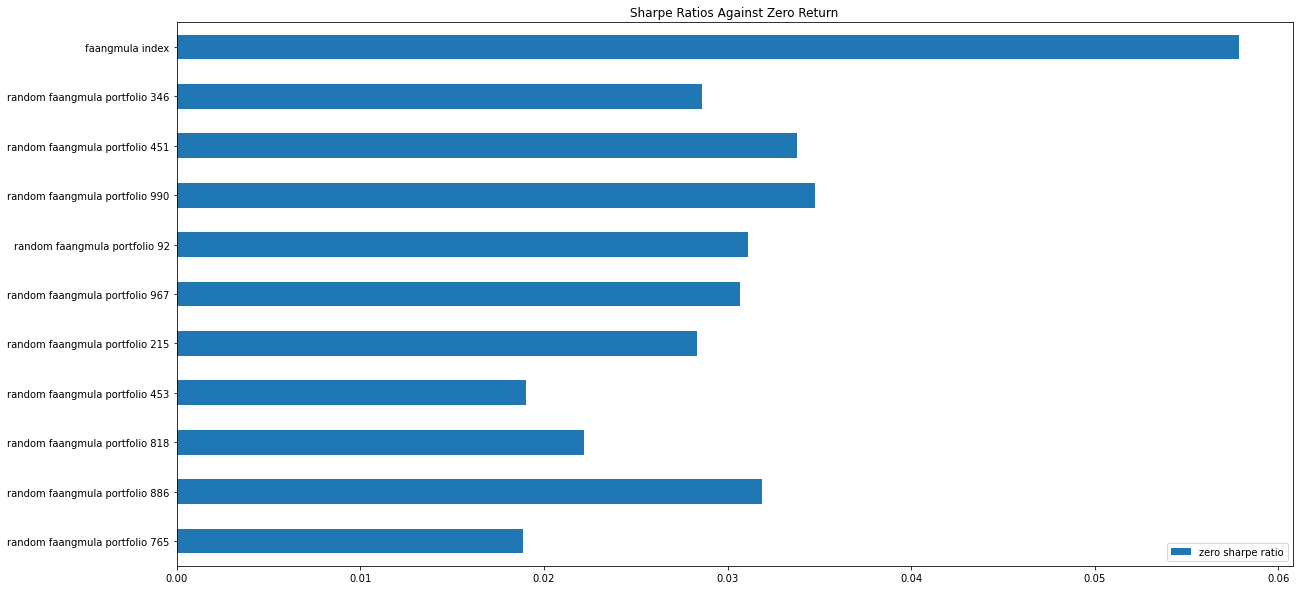

In [26]:
lc_intermediate_7.plot(kind = 'barh', x = 'portfolio', y = 'zero sharpe ratio', xlabel = '', ylabel = 'Sharpe Ratio Against Zero Return', figsize = (20, 10), title = 'Sharpe Ratios Against Zero Return')

In [27]:
#from datetime import datetime
#import requests
#import json

In [28]:
#def coinapi_data(tickers):
   
    #headers = {'X-CoinAPI-Key' : 'DABB5DFC-447C-4F57-8600-147722F5C7BA'}

    #coinapi_data = {}
    #for ticker in tickers:
        #url = f'https://rest.coinapi.io/v1/exchangerate/{ticker}/USD/history?period_id=1DAY&time_start=2019-01-01T00:00:00&time_end=2022-04-10T00:00:00&limit=900'
        #url = f'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_{ticker}_USD/history?period_id=1DAY&time_start=2019-01-01T00:00:00&time_end=2022-02-01T00:00:00&limit=900'
        #url = f'https://rest.coinapi.io/v1/ohlcv/BINANCE_SPOT_{ticker}_USDT/history?period_id=1DAY&time_start=2019-01-01T00:00:00&time_end=2022-02-01T00:00:00&limit=900'
        #response = requests.get(url, headers=headers)
        #print(response)
        
        #print(json.loads(response.content))
        #ticker_data = pd.DataFrame(json.loads(response.content))

        #ticker_data['symbol'] = ticker
        #ticker_data = ticker_data.rename(columns = {'time_period_end': 'timestamp', 'price_close': 'close'})
        #ticker_data = ticker_data.drop(['time_period_start', 'time_open', 'time_close', 'rate_open', 'rate_high', 'rate_low'], axis=1).reset_index()
        #ticker_data = ticker_data.drop(['time_period_start', 'time_open', 'time_close', 'price_open', 'price_high', 'price_low', 'volume_traded', 'trades_count'], axis=1).reset_index()
        #ticker_data = ticker_data.set_index('timestamp')
        #coinapi_data[ticker] = ticker_data

        #time.sleep(5)
        
    #return coinapi_data

In [29]:
#tickers = ['BTC', 'ETH', 'LUNA', 'SOL', 'XRP', 'ADA', 'AVAX', 'DOT', 'DOGE', 'SHIB', 'MATIC', 'DAI', 'LTC', 'ATOM', 'LINK', 'UNI', 'TRX', 'BCH']
#two_tickers = ['BTC', 'ETH']
#crypto_original = coinapi_data(tickers)

In [30]:
#crypto_original = pd.concat(crypto_original.values(), keys = crypto_original.keys(), axis = 'columns')
#crypto = crypto_original.xs('close', level = 1, axis = 'columns').dropna()
#crypto.index = crypto.index.astype('datetime64[ns]')
#crypto

In [31]:
#crypto.to_csv('./crypto_2.csv')

In [32]:
#all_close = pd.concat([faangmula, crypto], axis = 1, join = 'inner')
#all_close